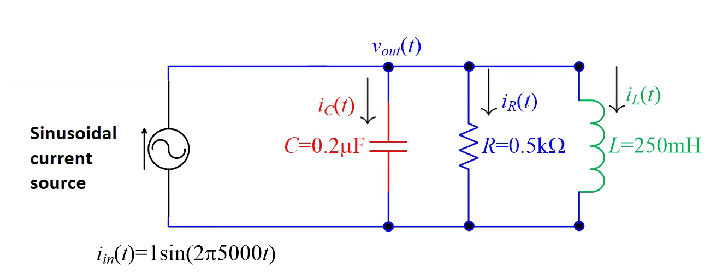

----------
Impedances
----------
Resistor Impedance =500 Ω
Capacitor Impedance = 0.00-159.15j Ω
Inductor Impedance = 0.00+1570.80j Ω
Alpha =5k rad/s
Omega_0 =10k rad/s
Damping ratio =500m
-----------
Parallel RLC circuit is underdamped
-----------


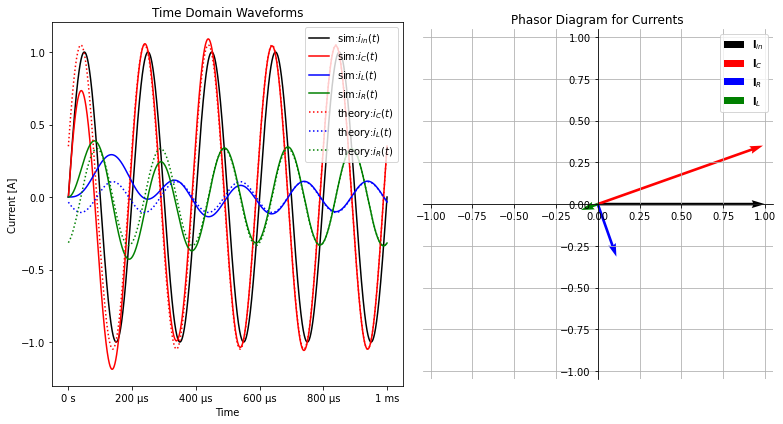

In [1]:

##*********************************************
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.pyplot import semilogx
from matplotlib import pyplot

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from engineering_notation import EngNumber

from matplotlib.ticker import EngFormatter

##*********************************************
circuit = Circuit('Parallel RLC Circuit')

Ia=1@u_A
f= 5@u_kHz
Io=0
Td=0
Df=0

circuit.SinusoidalCurrentSource(1, 'd', 'input', 
                                amplitude=Ia, frequency = f, offset
                                = Io, delay = Td, damping_factor =Df)
circuit.V(4, circuit.gnd, 'd',           0@u_V)

# Set R = 200 for over damped, R = 250 for critically damped and R=500 for under damped
R1 = circuit.R(1, 'input', 'a', 500@u_Ω)
circuit.V(1, 'a', circuit.gnd,           0@u_V)

L1 = circuit.L(1, 'input', 'b', 50@u_mH)
circuit.V(2, 'b', circuit.gnd,           0@u_V)

C1 = circuit.C(1, 'input', 'c', 0.2@u_uF)
circuit.V(3, 'c', circuit.gnd,           0@u_V)

steptime=0.1@u_us
finaltime = 5*(1/f)

##*********************************************
## 
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=steptime, end_time=finaltime)

##*********************************************
## 

# steady-state output voltage
time=np.array(analysis.time)
Iin = Ia
Z_R = circuit.R1.resistance
Z_C = (1/(1j* 2*math.pi*f*circuit.C1.capacitance))
Z_L = 1j* 2*math.pi*f*circuit.L1.inductance

Z_T = 1/((1/Z_R) + (1/Z_C) + (1/Z_L))

IL = (Z_T/Z_L)*Iin
IR = (Z_T/Z_R)*Iin
IC = (Z_T/Z_C)*Iin
iC= abs(IC)*np.sin(2*math.pi*f*time+np.angle(IC))
iR = abs(IR)*np.sin(2*math.pi*f*time+np.angle(IR))
iL = abs(IL)*np.sin(2*math.pi*f*time+np.angle(IL))

print ('----------')
print ('Impedances')
print ('----------')
print('Resistor Impedance ={} Ω'.format(EngNumber(float(Z_R))))
print('Capacitor Impedance = {:.2f} Ω'.format(Z_C))
print('Inductor Impedance = {:.2f} Ω'.format(Z_L))

alpha = float(1/(2*circuit.R1.resistance*circuit.C1.capacitance))
omega0 = float(math.sqrt(1/(circuit.L1.inductance*circuit.C1.capacitance)))
damping_ratio = float(alpha/omega0)

print('Alpha ={} rad/s'.format(EngNumber(alpha)))
print('Omega_0 ={} rad/s'.format(EngNumber(omega0)))
print('Damping ratio ={}'.format(EngNumber(damping_ratio)))

if damping_ratio == 1:
    print('-----------------')
    print('Parallel RLC circuit is critically damped')
    print('-----------------')
elif damping_ratio > 1:
    print('-----------')
    print('Parallel RLC circuit is overdamped')
    print('------------')
else:
    print('-----------')
    print('Parallel RLC circuit is underdamped')
    print('-----------')
    

##*********************************************

figure = plt.subplots(figsize=(11, 6))

axe = plt.subplot(121)
plt.title('Time Domain Waveforms')
plt.xlabel('Time')
plt.ylabel('Current [A]')
plt.grid

formatter0 = EngFormatter(unit='s')
axe.xaxis.set_major_formatter(formatter0)

plot(analysis.branches[('v4')], 'k')
plot(analysis.branches[('v3')], 'r')
plot(analysis.branches[('v2')], 'b')
plot(analysis.branches[('v1')], 'g')

plt.plot(time, iC,'r:')
plt.plot(time, iL,'b:')
plt.plot(time, iR,'g:')
plt.legend(('sim:$i_{in}(t)$','sim:$i_{C}(t)$', 'sim:$i_{L}(t)$',
            'sim:$i_{R}(t)$','theory:$i_{C}(t)$', 'theory:$i_{L}(t)$',
            'theory:$i_{R}(t)$'), loc='upper right')
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)


##*********************************************
## Plotting Phasor Diagram

#figure = plt.subplots(figsize=(11, 6))
axe = plt.subplot(122)

plt.title('Phasor Diagram for Currents')

axe.quiver(0, 0, float(Iin), 0,units='xy' ,scale=1,color='k')
axe.quiver(0, 0, np.array((np.real(IC))), np.array((np.imag(IC))),units='xy' ,scale=1, color='r')
axe.quiver(0, 0, np.array((np.real(IR))), np.array((np.imag(IR))),units='xy' ,scale=1, color='b')
axe.quiver(0, 0, np.array((np.real(IL))), np.array((np.imag(IL))),units='xy' ,scale=1, color='g')

plt.grid()
axe.set_aspect('equal')
axe.spines['left'].set_position('zero')
axe.spines['right'].set_color('none')
axe.spines['bottom'].set_position('zero')
axe.spines['top'].set_color('none')

limit = max(float(Ia),np.amax(abs(IC)),np.amax(abs(IR)),np.amax(abs(IL)))
plt.xlim(-limit,limit)
plt.ylim(-limit,limit)
plt.legend(('$\mathbf{I}_{in}$','$\mathbf{I}_{C}$', '$\mathbf{I}_{R}$', '$\mathbf{I}_{L}$'))

plt.tight_layout()
plt.show()